<a href="https://colab.research.google.com/github/dansarmiento/MachineLearning/blob/main/Multi_Class_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This workbook accomplishes the following:
- use one-hot encoding for categorical variables
- implement logistic regression for multi-class classification using one-vs-all and one-vs-one strategies
- evaluate model performance using appropriate metrics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [7]:
# https://docs.google.com/spreadsheets/d/15EI4TrEP5hP35htmziRSNi4p56fpR9kMXwZn2d1DErg/edit?usp=sharing

sheet_id = "15EI4TrEP5hP35htmziRSNi4p56fpR9kMXwZn2d1DErg"
sheet_name = "Sheet1"

gsheet_url = "https://docs.google.com/spreadsheets/d/{}/gviz/tq?tqx=out:csv&sheet={}".format(sheet_id,sheet_name)
df = pd.read_csv(gsheet_url)
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('/','_')
df.head()

,gender,age,height,weight,family_history_with_overweight,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,nobeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


| Variable Name               | Type        | Description                                                                 |
|----------------------------|-------------|-----------------------------------------------------------------------------|
| Gender                     | Categorical |                                                                             |
| Age                        | Continuous  |                                                                             |
| Height                     | Continuous  |                                                                             |
| Weight                     | Continuous  |                                                                             |
| family_history_with_overweight | Binary   | Has a family member suffered or suffers from overweight?                   |
| FAVC                       | Binary      | Do you eat high caloric food frequently?                                   |
| FCVC                       | Integer     | Do you usually eat vegetables in your meals?                               |
| NCP                        | Continuous  | How many main meals do you have daily?                                     |
| CAEC                       | Categorical | Do you eat any food between meals?                                         |
| SMOKE                      | Binary      | Do you smoke?                                                              |
| CH2O                       | Continuous  | How much water do you drink daily?                                         |
| SCC                        | Binary      | Do you monitor the calories you eat daily?                                 |
| FAF                        | Continuous  | How often do you have physical activity?                                   |
| TUE                        | Integer     | How much time do you use technological devices (phone, videogames, etc.)? |
| CALC                       | Categorical | How often do you drink alcohol?                                            |
| MTRANS                     | Categorical | Which transportation do you usually use?                                   |
| NObeyesdad                 | Categorical | Obesity level                                                              |


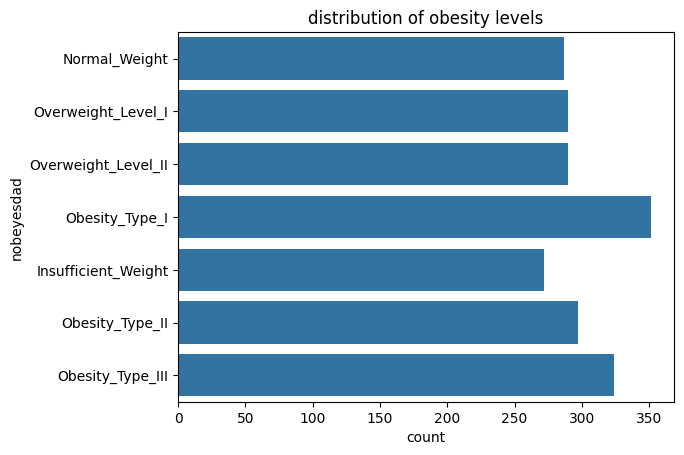

In [8]:
#  Start with exploratory data analysis

sns.countplot(y='nobeyesdad', data=df)
plt.title('distribution of obesity levels')
plt.show()

In [9]:
# look for missing values - appears to be complete dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          2111 non-null   object 
 1   age                             2111 non-null   float64
 2   height                          2111 non-null   float64
 3   weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   favc                            2111 non-null   object 
 6   fcvc                            2111 non-null   float64
 7   ncp                             2111 non-null   float64
 8   caec                            2111 non-null   object 
 9   smoke                           2111 non-null   object 
 10  ch2o                            2111 non-null   float64
 11  scc                             2111 non-null   object 
 12  faf                             21

**preprocessing the data**

In [10]:
continuous_columns = df.select_dtypes(include=['int64', 'float64']).columns


scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[continuous_columns])

scaled_df = pd.DataFrame(scaled_features, columns=scaler.get_feature_names_out(continuous_columns))

scaled_data = pd.concat([df.drop(columns=continuous_columns), scaled_df], axis=1)
scaled_data.head()

,gender,family_history_with_overweight,favc,caec,smoke,scc,calc,mtrans,nobeyesdad,age,height,weight,fcvc,ncp,ch2o,faf,tue
0,Female,yes,no,Sometimes,no,no,no,Public_Transportation,Normal_Weight,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997
1,Female,yes,no,Sometimes,yes,yes,Sometimes,Public_Transportation,Normal_Weight,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625
2,Male,yes,no,Sometimes,no,no,Frequently,Public_Transportation,Normal_Weight,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997
3,Male,no,no,Sometimes,no,no,Frequently,Walking,Overweight_Level_I,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625
4,Male,no,no,Sometimes,no,no,Sometimes,Public_Transportation,Overweight_Level_II,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625


In [11]:
# one hot encoding
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# exclude target variable
categorical_columns.remove('nobeyesdad')

# apply one hot encoding
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = encoder.fit_transform(scaled_data[categorical_columns])

encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

prepped_data = pd.concat([scaled_data.drop(columns=categorical_columns), encoded_df], axis=1)
prepped_data.head()

,nobeyesdad,age,height,weight,fcvc,ncp,ch2o,faf,tue,gender_Male,...,caec_no,smoke_yes,scc_yes,calc_Frequently,calc_Sometimes,calc_no,mtrans_Bike,mtrans_Motorbike,mtrans_Public_Transportation,mtrans_Walking
0,Normal_Weight,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,Normal_Weight,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,Normal_Weight,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,Overweight_Level_I,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Overweight_Level_II,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [12]:
# encode the target variable

prepped_data['nobeyesdad'] = prepped_data.nobeyesdad.astype('category').cat.codes
prepped_data.head()

,nobeyesdad,age,height,weight,fcvc,ncp,ch2o,faf,tue,gender_Male,...,caec_no,smoke_yes,scc_yes,calc_Frequently,calc_Sometimes,calc_no,mtrans_Bike,mtrans_Motorbike,mtrans_Public_Transportation,mtrans_Walking
0,1,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,5,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,6,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [13]:
# separate the dependent and independent variables

X = prepped_data.drop(columns='nobeyesdad')
y = prepped_data.nobeyesdad

In [14]:
# model training and evaluation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


**logistic regression with one vs all**

in this approach the algorithm trains a single binary classifier for each class, then each classifier learns to distinguish a single class from all others combined, if there are k classes, k classifiers are trained.  During prediction, the algorithm evaluates all classifiers on each input and selects the class with the highest confidence score

advantages:
- simpler and more efficient in terms of the number of classifiers (k)
- easier to implement for algorithms that naturally provide confidence scores

disadvantages:
- classifiers may struggle with class imbalance
- requires the classifier to perform well even with highly imbalanced datasets

In [15]:
# one versus all

model_ova = LogisticRegression(multi_class='ovr', max_iter=1000)
model_ova.fit(X_train, y_train)
y_pred_ova = model_ova.predict(X_test)
accuracy_ova = accuracy_score(y_test, y_pred_ova)

print(f'accuracy with one vs all: {accuracy_ova}')

accuracy with one vs all: 0.7612293144208038


**logistic regression with one vs one**

in this approach, the algorithm trains a binary classifier for every pair of classes in the dataset.  if there are k classes, this results in k(k-1)/2 classifiers.  each classifier is trained to distinguish between two specific classes, ignoring the rest. during prediction, all classifiers are used, and a voting mechanism decides the final class by selecting the class that wins the majority of pairwise comparisons

advantages:
- suitable for algorithms that are computationally expensive to train on many samples
- can be more accurage in some cases since classifiers focus on distinguishing between two specific classes at a time

disadvatages:
- computationally expensive for datasets with a large number of classes due to the large number of classifiers required
- may lead to ambiguous predictions if voting results in a tie

In [17]:
# one versus one
model_ovo = OneVsOneClassifier(LogisticRegression(max_iter=1000))
model_ovo.fit(X_train, y_train)
y_pred_ovo = model_ovo.predict(X_test)
accuracy_ovo = accuracy_score(y_test, y_pred_ovo)

print(f'accuracy with one vs one: {accuracy_ovo}')

accuracy with one vs one: 0.9219858156028369


In [18]:
# experiment with different test sizes to observe the impact on model performance
for test_size in [0.1, 0.3]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    model_ova.fit(X_train, y_train)
    y_pred = model_ova.predict(X_test)
    print(f"Test Size: {test_size}")
    print("Accuracy:", accuracy_score(y_test, y_pred))

Test Size: 0.1
Accuracy: 0.7594339622641509
Test Size: 0.3
Accuracy: 0.749211356466877


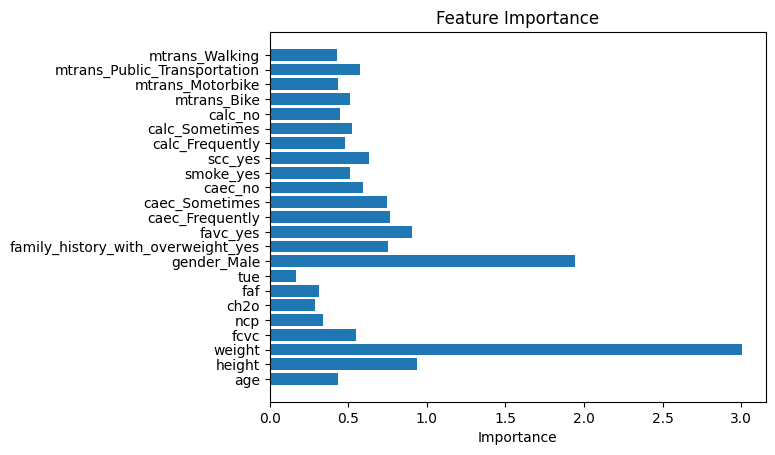

In [20]:
# bar chart of feature importance using the coefficients from both models

# Feature importance
feature_importance = np.mean(np.abs(model_ova.coef_), axis=0)
plt.barh(X.columns, feature_importance)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.show()




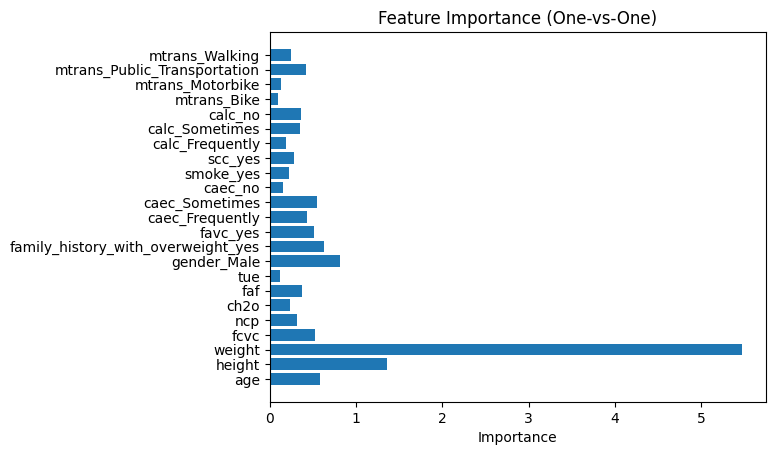

In [21]:
# Collect all coefficients from each underlying binary classifier
coefs = np.array([est.coef_[0] for est in model_ovo.estimators_])

# Now take the mean across all those classifiers
feature_importance = np.mean(np.abs(coefs), axis=0)

# Plot feature importance
plt.barh(X.columns, feature_importance)
plt.title("Feature Importance (One-vs-One)")
plt.xlabel("Importance")
plt.show()

In [ ]:
# function to automate the entire pipeline

def obesity_risk_pipeline(data_path, test_size=0.2):
    # Load data
    data = pd.read_csv(data_path)

    # Standardizing continuous numerical features
    continuous_columns = data.select_dtypes(include=['float64']).columns.tolist()
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data[continuous_columns])

    # Converting to a DataFrame
    scaled_df = pd.DataFrame(scaled_features, columns=scaler.get_feature_names_out(continuous_columns))

    # Combining with the original dataset
    scaled_data = pd.concat([data.drop(columns=continuous_columns), scaled_df], axis=1)

    # Identifying categorical columns
    categorical_columns = scaled_data.select_dtypes(include=['object']).columns.tolist()
    categorical_columns.remove('NObeyesdad')  # Exclude target column

    # Applying one-hot encoding
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded_features = encoder.fit_transform(scaled_data[categorical_columns])

    # Converting to a DataFrame
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

    # Combining with the original dataset
    prepped_data = pd.concat([scaled_data.drop(columns=categorical_columns), encoded_df], axis=1)

    # Encoding the target variable
    prepped_data['NObeyesdad'] = prepped_data['NObeyesdad'].astype('category').cat.codes

    # Preparing final dataset
    X = prepped_data.drop('NObeyesdad', axis=1)
    y = prepped_data['NObeyesdad']

    # Splitting data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    # Training and evaluation
    model = LogisticRegression(multi_class='multinomial', max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))